In [42]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob,os
import pathlib

from matplotlib import gridspec
from Bio import SeqIO
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import ConvexHull

base_path=pathlib.Path(os.path.abspath(''))
data_path=os.path.join(base_path, "data_pub_for_poly")

# 
def percent2dissim(matrix):
    convert=lambda percent: 1.0-(percent/100.0)

    for i,row in enumerate(matrix):
        for j,value in enumerate(matrix[i]):
            if i==j:
                matrix[i][j]=0.0
            elif j>i:
                matrix[i][j]=convert(matrix[i][j])
                matrix[j][i]=matrix[i][j]

    return matrix

# similarity
def percent_id(seqA,seqB):
    invalid=lambda aa: aa=='-' or aa=='X'
    ident=0
    diffs=0
    total=0
    for a,b in zip(seqA,seqB):
        if a!=b:
            diffs+=1
            total+=1
        elif invalid(a) or invalid(b):
            pass
        else:
            ident+=1
            total+=1

    return (ident/total)*100.0

distance_matrices={}
seq_names={}

# get input 
for aln_path in glob.glob(os.path.join(data_path,'*.aln')): 
    aln=SeqIO.parse(aln_path,format='fasta')
    vir=os.path.basename(aln_path).split('_')[0]
    seqs=[]
    seq_names[vir]=[]
    for seq in aln:
        seq_names[vir].append(seq.id) 
        seqs.append(seq.seq)

    matrix_fname=aln_path.replace('.aln','.v_matrix.tsv')
    matrix=np.zeros((len(seqs),len(seqs)))
    
    for a,seqA in enumerate(seqs):
        for b,seqB in enumerate(seqs):
            if b>a:
                diffs=percent_id(seqA,seqB)
                matrix[a][b]=diffs
                matrix[b][a]=diffs

    distance_matrices[vir]=percent2dissim(matrix)
    
    out=open(matrix_fname,'w')
    header=seq_names[vir]
    mm=distance_matrices[vir]
    out.write(',%s\n'%(','.join(header)))
    for e,entry in enumerate(mm):
        out.write('%s,%s\n'%(header[e],','.join(map(str,entry))))
    out.close()

    

In [44]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

MDS_XY={}
clusters={}
cluster_labels={}

mds=MDS(n_components=2,dissimilarity='precomputed', random_state=121)

for vir in distance_matrices:
    mds_file=os.path.join(data_path,'%s_MDS.csv'%(vir))
    MDS_XY[vir]=mds.fit_transform(distance_matrices[vir])
    ac=AgglomerativeClustering(n_clusters=3,metric='precomputed',linkage='complete')
    clusters[vir]=ac.fit(distance_matrices[vir])
    for n,name in enumerate(seq_names['Poly']): 
        cluster_labels[name]=clusters[vir].labels_[n]
        
    out=open(mds_file,'w')
    if vir in seq_names:
        for n,name in enumerate(seq_names[vir]):
            x,y=MDS_XY[vir][n]
            out.write('%s,%s,%s\n'%(name,x,y))
    out.close()


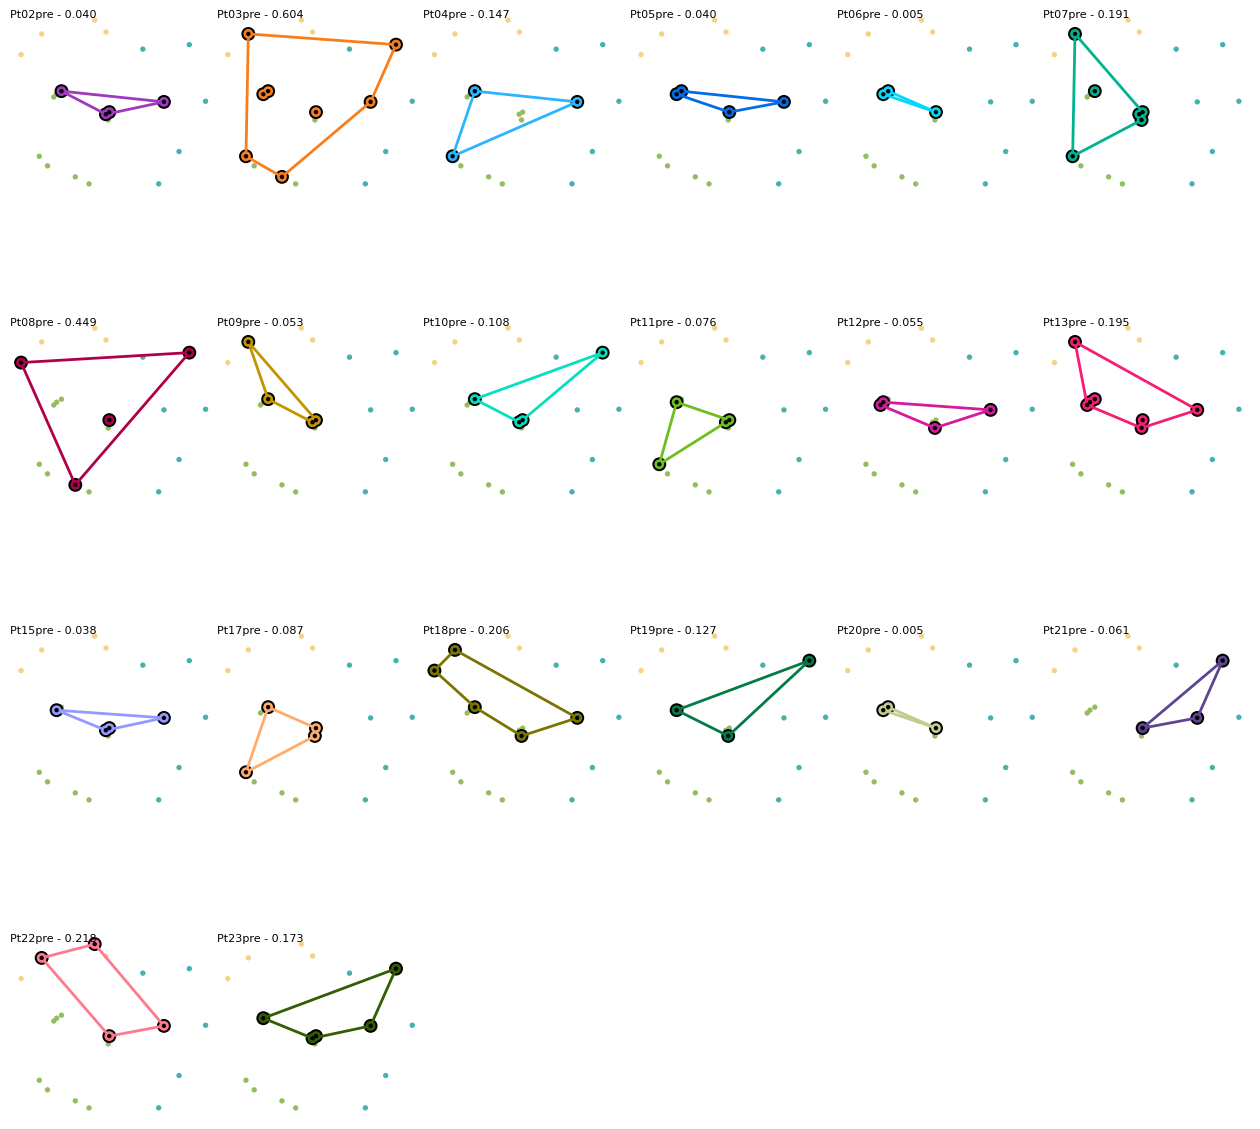

In [46]:
from collections import defaultdict
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_Polygon
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit


all_coordinates=[] # all poly coordinates
pid_seqs=defaultdict(list) # store each pid seq
pid_coordinates=defaultdict(list) # store each pid coordinates
pid_colours={} # store color for each pid

genus_color={"Alphapolyomavirus":"#46b2ac", "Betapolyomavirus":"#f7d186", "Deltapolyomavirus":"#94bc61"}

genus_df=os.path.join(data_path,'Poly_genus.txt')
if os.path.exists(genus_df):
     poly_genus={}
     for line in open(genus_df, "r"):
         items=line.strip("\n").split("\t")
         poly_genus[items[0]]=items[1]


poly_df=os.path.join(data_path,'Poly_input_from_all_reads_and_10m.txt')
if os.path.exists(poly_df): 
    poly_patient=defaultdict(list)
    for line in open(poly_df,'r'):
        items=line.strip("\n").split("\t")
        poly_patient[items[1]].append(items[0])
cs=[]
for n,name in enumerate(seq_names['Poly']):
    all_coordinates.append(MDS_XY['Poly'][n])
    cs.append(genus_color[poly_genus[name]])


# 6001pre, 6022pre not enough poly
target_pid =["Pt02pre", "Pt03pre", "Pt04pre", "Pt05pre", "Pt06pre", "Pt07pre", "Pt08pre", "Pt09pre", "Pt10pre",
            "Pt11pre", "Pt12pre", "Pt13pre", "Pt15pre", "Pt17pre", "Pt18pre", "Pt19pre",
            "Pt20pre", "Pt21pre", "Pt22pre", "Pt23pre"]

for pid in target_pid:
    target_poly=poly_patient[pid]
    for i in target_poly:
        indices=seq_names["Poly"].index(i)
        pid_coordinates[pid].append(MDS_XY['Poly'][indices])
        pid_seqs[pid].append(indices)

        
# get full area
hull = ConvexHull(np.array(all_coordinates))
sh_poly=Polygon(list(zip(np.array(all_coordinates)[hull.vertices,0],np.array(all_coordinates)[hull.vertices,1])))      
total_area=sh_poly.area

fig = plt.figure(figsize=(8*2,8*2),facecolor='w')
cols = 6
gs = gridspec.GridSpec(len(target_pid)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0)
col_20 = ["#9F39BF", "#F97E1B", "#2BB5FF", "#026BE7", "#01D8FB", "#00B28E", "#B0004A", "#C19400", "#05DFBF", "#6EBD21", "#D51A9F", "#F71C74",
         "#9498FF", "#FFAB6A", "#7A7500", "#007C47", "#C5CB8D", "#5E4492", "#FF798F", "#325E02"]

all_area = {}

for p,patient in enumerate(sorted(target_pid)):
    distances=[]
    pid_colours[patient]=col_20[p]
    for a,A in enumerate(pid_seqs[patient]):
        for b,B in enumerate(pid_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Poly'][A][B])
                
    xs,ys=zip(*pid_coordinates[patient]) # define xs, ys
    fc=pid_colours[patient]
    coords=np.array(np.array((xs,ys)).T)
    hull = ConvexHull(coords)
    sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
    
    row=p//cols
    col=p%cols
    ax=plt.subplot(gs[row,col])
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*10,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*20,facecolor='k',edgecolor='none',zorder=2)

    
    for simplex in hull.simplices:
        ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=2,ls='-',zorder=3)
        #ax.plot(coords[simplex,0],coords[simplex,1],color='k',lw=2,ls='--',zorder=0)
        
    area='- %.3f'%(sh_poly.area/total_area) 
    area_value=sh_poly.area/total_area
    all_area[patient] = area_value
    ax.text(0.0,1,'%s %s'%(patient,area),size=8,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=15,facecolor=cs,edgecolor='none',zorder=1)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig(os.path.join(data_path, 'figures', 'poly_hull_area_all_reads.pdf'),dpi=300,bbox_inches='tight')
plt.show()

#import numpy as np
#import pandas as pd

#area_values = np.array(list(all_area.values()))  
#area_quantiles = np.quantile(area_values, [0.25, 0.5, 0.75])  # Calculate quantiles
#print(area_quantiles)

# Proceed with the "number of poly" computation
#num_poly = [(k, len(v)) for k, v in poly_patient.items() if k in target_pid]  
#df_poly_num = pd.DataFrame(num_poly, columns=['Key', 'Number of Poly'])  

#df_area = pd.DataFrame(list(all_area.items()), columns=['Key', 'area'])
#merged_df_poly = pd.merge(df_poly_num, df_area, on='Key')

#print(merged_df_poly)

In [15]:
# papillomaviruses
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob,os
import pathlib

from matplotlib import gridspec
from Bio import SeqIO
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import ConvexHull

base_path=pathlib.Path(os.path.abspath(''))
data_path=os.path.join(base_path, "data_pub_for_papi")

# 
def percent2dissim(matrix):
    convert=lambda percent: 1.0-(percent/100.0)

    for i,row in enumerate(matrix):
        for j,value in enumerate(matrix[i]):
            if i==j:
                matrix[i][j]=0.0
            elif j>i:
                matrix[i][j]=convert(matrix[i][j])
                matrix[j][i]=matrix[i][j]

    return matrix

# similarity
def percent_id(seqA,seqB):
    invalid=lambda aa: aa=='-' or aa=='X'
    ident=0
    diffs=0
    total=0
    for a,b in zip(seqA,seqB):
        if a!=b:
            diffs+=1
            total+=1
        elif invalid(a) or invalid(b):
            pass
        else:
            ident+=1
            total+=1

    return (ident/total)*100.0

distance_matrices={}
seq_names={}

# get input 
for aln_path in glob.glob(os.path.join(data_path,'*.aln')): 
    aln=SeqIO.parse(aln_path,format='fasta')
    vir=os.path.basename(aln_path).split('_')[0]
    seqs=[]
    seq_names[vir]=[]
    for seq in aln:
        seq_names[vir].append(seq.id) 
        seqs.append(seq.seq)

    matrix_fname=aln_path.replace('.aln','.v_matrix.tsv')
    matrix=np.zeros((len(seqs),len(seqs)))
    
    for a,seqA in enumerate(seqs):
        for b,seqB in enumerate(seqs):
            if b>a:
                diffs=percent_id(seqA,seqB)
                matrix[a][b]=diffs
                matrix[b][a]=diffs

    distance_matrices[vir]=percent2dissim(matrix)
    
    out=open(matrix_fname,'w')
    header=seq_names[vir]
    mm=distance_matrices[vir]
    out.write(',%s\n'%(','.join(header)))
    for e,entry in enumerate(mm):
        out.write('%s,%s\n'%(header[e],','.join(map(str,entry))))
    out.close()


In [17]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

MDS_XY={}
clusters={}
cluster_labels={}

mds=MDS(n_components=2,dissimilarity='precomputed', random_state=329) 

for vir in distance_matrices:
    mds_file=os.path.join(data_path,'%s_MDS.csv'%(vir))
    MDS_XY[vir]=mds.fit_transform(distance_matrices[vir])
    ac=AgglomerativeClustering(n_clusters=5,metric='precomputed',linkage='complete')
    clusters[vir]=ac.fit(distance_matrices[vir])
    for n,name in enumerate(seq_names['Papi']): 
        cluster_labels[name]=clusters[vir].labels_[n]
        
    out=open(mds_file,'w')
    if vir in seq_names:
        for n,name in enumerate(seq_names[vir]):
            x,y=MDS_XY[vir][n]
            out.write('%s,%s,%s\n'%(name,x,y))
    out.close()

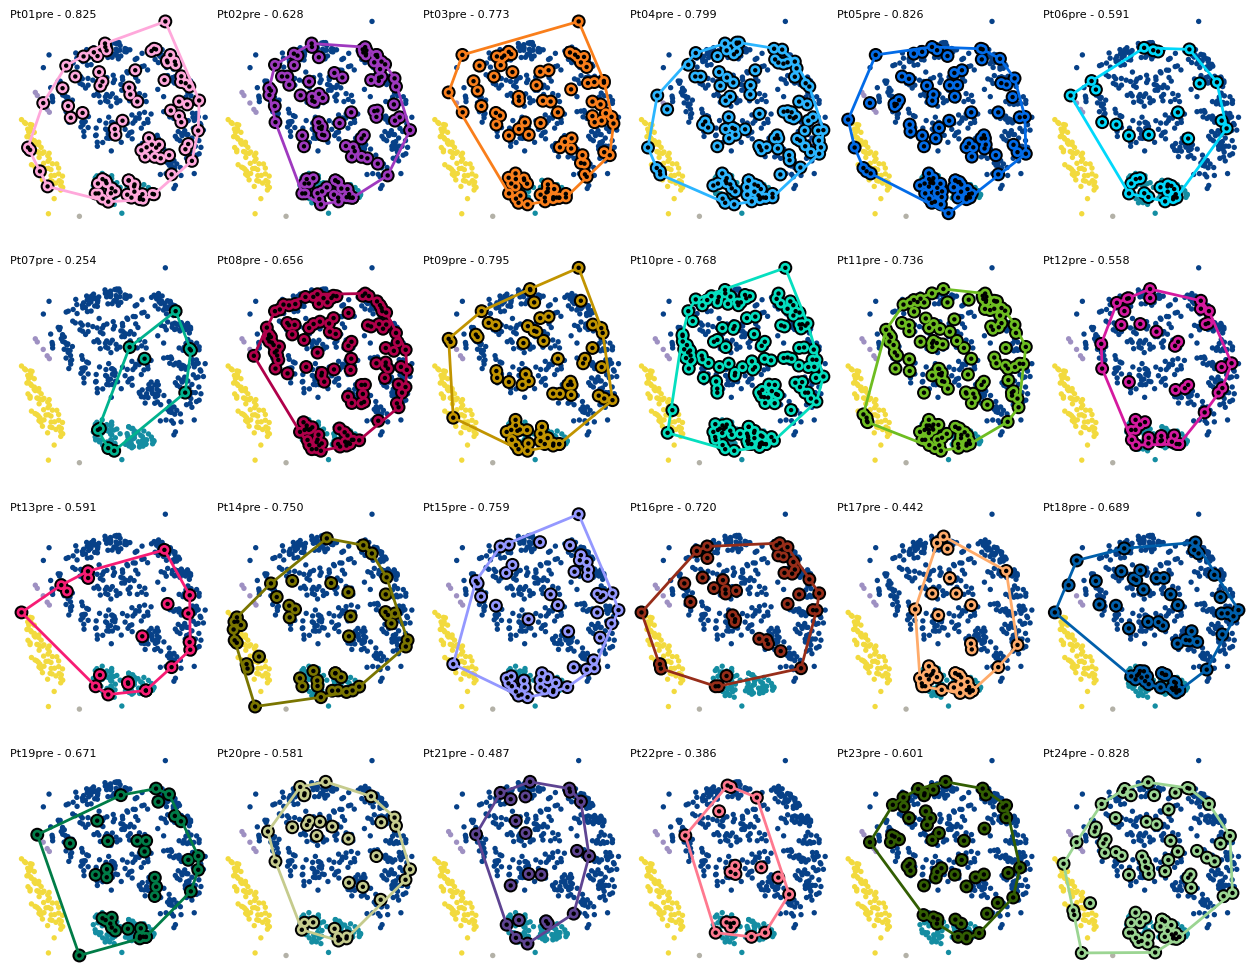

In [27]:
# Supplementary 3b
from collections import defaultdict
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_Polygon
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit


all_coordinates=[] # all poly coordinates
pid_seqs=defaultdict(list) # store each pid seq
pid_coordinates=defaultdict(list) # store each pid coordinates
pid_colours={} # store color for each pid

genus_color={"Alphapapillomavirus":"#f2da3e", "Betapapillomavirus":"#148da2", "Gammapapillomavirus":"#074188", "Mupapillomavirus":"#9e90c2",
            "Nupapillomavirus":"#b3b1a7"}

genus_df=os.path.join(data_path,'Papi_genus.txt')
if os.path.exists(genus_df):
     papi_genus={}
     for line in open(genus_df, "r"):
         items=line.strip("\n").split("\t")
         papi_genus[items[0]]=items[1]


papi_df=os.path.join(data_path,'Papi_input_from_all_reads_and_10m.txt')
if os.path.exists(papi_df): 
    papi_patient=defaultdict(list)
    for line in open(papi_df,'r'):
        items=line.strip("\n").split("\t")
        papi_patient[items[1]].append(items[0])
cs=[]
for n,name in enumerate(seq_names['Papi']):
    all_coordinates.append(MDS_XY['Papi'][n])
    cs.append(genus_color[papi_genus[name]])


# 
target_pid =["Pt01pre", "Pt02pre", "Pt03pre", "Pt04pre", "Pt05pre", "Pt06pre", "Pt07pre", "Pt08pre", "Pt09pre", "Pt10pre",
            "Pt11pre", "Pt12pre", "Pt13pre", "Pt14pre", "Pt15pre", "Pt16pre", "Pt17pre", "Pt18pre", "Pt19pre",
            "Pt20pre", "Pt21pre", "Pt22pre", "Pt23pre", "Pt24pre"]

for pid in target_pid:
    target_papi=papi_patient[pid]
    for i in target_papi:
        indices=seq_names["Papi"].index(i)
        pid_coordinates[pid].append(MDS_XY['Papi'][indices])
        pid_seqs[pid].append(indices)

        
# get full area
hull = ConvexHull(np.array(all_coordinates))
sh_poly=Polygon(list(zip(np.array(all_coordinates)[hull.vertices,0],np.array(all_coordinates)[hull.vertices,1])))      
total_area=sh_poly.area

fig = plt.figure(figsize=(8*2,8*2),facecolor='w')
cols = 6
gs = gridspec.GridSpec(len(target_pid)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0)
col_24 = ["#ffa8db", "#9f39bf", "#f97e1b", "#2bb5ff", "#026be7", "#01d8fb", "#00b28e", "#b0004a", "#c19400", "#05dfbf", "#6ebd21", "#d51a9f", 
          "#f71c74", "#7a7500", "#9498ff", "#972d19", "#ffab6a", "#005fab", "#007c47", "#c5cb8d", "#5e4492", "#ff798f", "#325e02", "#9bd592"]


all_area = {}

for p,patient in enumerate((target_pid)):
    distances=[]
    pid_colours[patient]=col_24[p]
    for a,A in enumerate(pid_seqs[patient]):
        for b,B in enumerate(pid_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Papi'][A][B])
                
    xs,ys=zip(*pid_coordinates[patient]) # define xs, ys
    fc=pid_colours[patient]
    coords=np.array(np.array((xs,ys)).T)
    hull = ConvexHull(coords)
    sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
    
    row=p//cols
    col=p%cols
    ax=plt.subplot(gs[row,col])
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*10,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*20,facecolor='k',edgecolor='none',zorder=2)

    
    for simplex in hull.simplices:
        ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=2,ls='-',zorder=3)
        #ax.plot(coords[simplex,0],coords[simplex,1],color='k',lw=2,ls='--',zorder=0)
        
    area='- %.3f'%(sh_poly.area/total_area) 
    area_value=sh_poly.area/total_area
    all_area[patient] = area_value
    ax.text(0.0,1,'%s %s'%(patient,area),size=8,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=15,facecolor=cs,edgecolor='none',zorder=1)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig(os.path.join(data_path, 'figures', 'papi_hull_area_all_reads.pdf'),dpi=300,bbox_inches='tight')
plt.show()

#import numpy as np
#import pandas as pd

#area_values = np.array(list(all_area.values()))  # Extract values from the dictionary
#area_quantiles = np.quantile(area_values, [0.25, 0.5, 0.75])  # Calculate quantiles
#print(area_quantiles)

# Proceed with other operations
#num_papi = [(k, len(v)) for k, v in papi_patient.items() if k in target_pid]
#df_papi_num = pd.DataFrame(num_papi, columns=['Key', 'Number of Papi'])
#df_area = pd.DataFrame(list(all_area.items()), columns=['Key', 'area'])

# Merge dataframes
#merged_df_papi = pd.merge(df_papi_num, df_area, on='Key')
#print(merged_df_papi)

# Calculate quantiles for the "Number of Papi" column
#papi_quantiles = merged_df_papi["Number of Papi"].quantile([0.25, 0.5, 0.75])
#print(papi_quantiles)

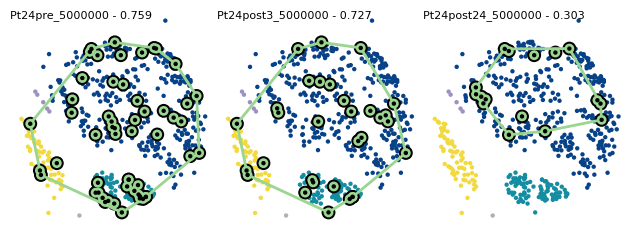

In [21]:
# Figure3D
# using results from normalized results
Pt24 =["Pt24pre_5000000", "Pt24post3_5000000", "Pt24post24_5000000"]
for pid in Pt24:
    target_papi=papi_patient[pid]
    for i in target_papi:
        indices=seq_names["Papi"].index(i)
        pid_coordinates[pid].append(MDS_XY['Papi'][indices])
        pid_seqs[pid].append(indices)

# get full area
hull = ConvexHull(np.array(all_coordinates))
sh_poly=Polygon(list(zip(np.array(all_coordinates)[hull.vertices,0],np.array(all_coordinates)[hull.vertices,1])))      
total_area=sh_poly.area

fig = plt.figure(figsize=(8*2,8*2),facecolor='w')
cols = 6
gs = gridspec.GridSpec(len(target_pid)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0)
col_Pt24 = ["#9bd592", "#9bd592", "#9bd592"]

for p,patient in enumerate(Pt24):
    distances=[]
    pid_colours[patient]=col_Pt24[p]
    for a,A in enumerate(pid_seqs[patient]):
        for b,B in enumerate(pid_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Papi'][A][B])
                
    xs,ys=zip(*pid_coordinates[patient]) # define xs, ys
    fc=pid_colours[patient]
    coords=np.array(np.array((xs,ys)).T)
    hull = ConvexHull(coords)
    sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
    
    row=p//cols
    col=p%cols
    ax=plt.subplot(gs[row,col])
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*10,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*20,facecolor='k',edgecolor='none',zorder=2)
    
    for simplex in hull.simplices:
        ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=2,ls='-',zorder=3)
        #ax.plot(coords[simplex,0],coords[simplex,1],color='k',lw=2,ls='--',zorder=0)
        
    area='- %.3f'%(sh_poly.area/total_area) 
    ax.text(0.0,1,'%s %s'%(patient,area),size=8,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=10,facecolor=cs,edgecolor='none',zorder=1)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig(os.path.join(data_path, 'figures', 'pt24_hull_area_from_10m.pdf'),dpi=300,bbox_inches='tight')
plt.show()


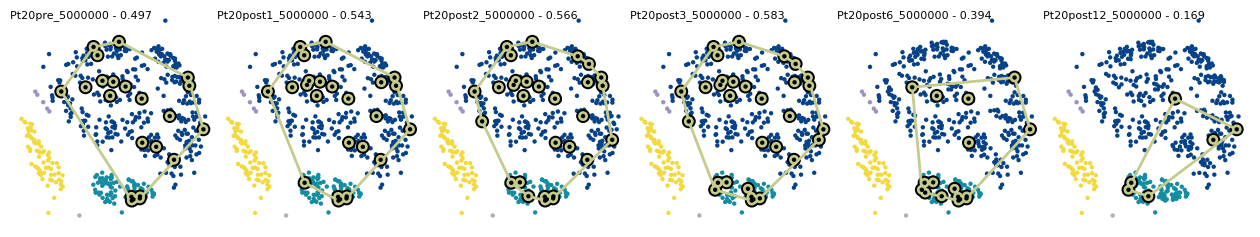

In [25]:
# Fig1g Pt20
# using results from normalized results
Pt20 =["Pt20pre_5000000", "Pt20post1_5000000", "Pt20post2_5000000", "Pt20post3_5000000", "Pt20post6_5000000", "Pt20post12_5000000"]

for pid in Pt20:
    target_papi=papi_patient[pid]
    for i in target_papi:
        indices=seq_names["Papi"].index(i)
        pid_coordinates[pid].append(MDS_XY['Papi'][indices])
        pid_seqs[pid].append(indices)

# get full area
hull = ConvexHull(np.array(all_coordinates))
sh_poly=Polygon(list(zip(np.array(all_coordinates)[hull.vertices,0],np.array(all_coordinates)[hull.vertices,1])))      
total_area=sh_poly.area

fig = plt.figure(figsize=(8*2,8*2),facecolor='w')
cols = 6
gs = gridspec.GridSpec(len(target_pid)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0)
col_Pt20 = ["#c5cb8d", "#c5cb8d", "#c5cb8d", "#c5cb8d", "#c5cb8d", "#c5cb8d"]

for p,patient in enumerate(Pt20):
    distances=[]
    pid_colours[patient]=col_Pt20[p]
    for a,A in enumerate(pid_seqs[patient]):
        for b,B in enumerate(pid_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Papi'][A][B])
                
    xs,ys=zip(*pid_coordinates[patient]) # define xs, ys
    fc=pid_colours[patient]
    coords=np.array(np.array((xs,ys)).T)
    hull = ConvexHull(coords)
    sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
    
    row=p//cols
    col=p%cols
    ax=plt.subplot(gs[row,col])
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*10,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*20,facecolor='k',edgecolor='none',zorder=2)
    
    for simplex in hull.simplices:
        ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=2,ls='-',zorder=3)
        #ax.plot(coords[simplex,0],coords[simplex,1],color='k',lw=2,ls='--',zorder=0)
        
    area='- %.3f'%(sh_poly.area/total_area) 
    ax.text(0.0,1,'%s %s'%(patient,area),size=8,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=10,facecolor=cs,edgecolor='none',zorder=1)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig(os.path.join(data_path, 'figures', 'pt20_hull_area_from_10m.pdf'),dpi=300,bbox_inches='tight')
plt.show()


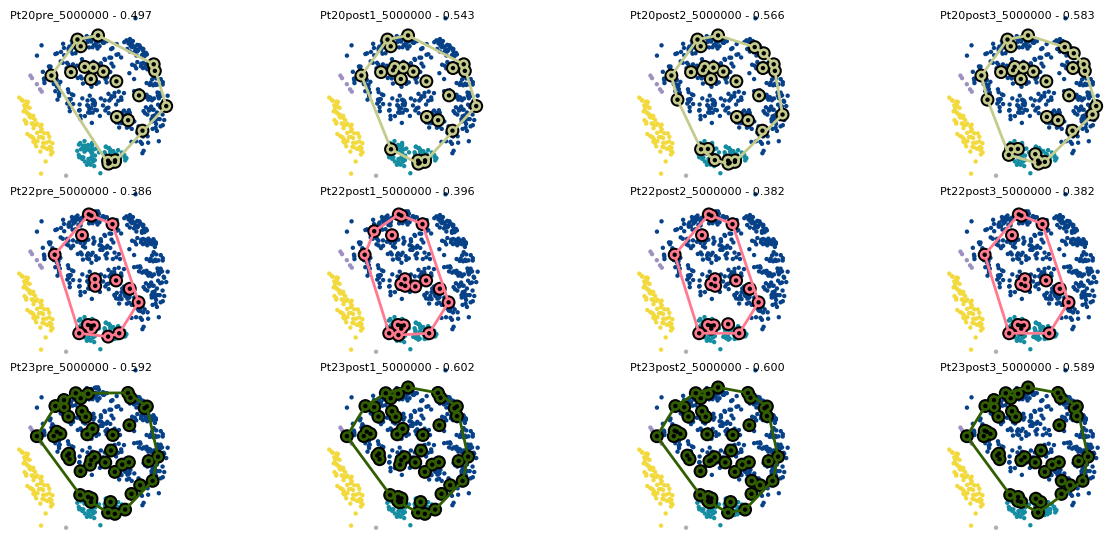

In [23]:
# Supplementary figure 8a
target_early_post =["Pt20pre_5000000", "Pt20post1_5000000", "Pt20post2_5000000", "Pt20post3_5000000", "Pt22pre_5000000", 
                   "Pt22post1_5000000", "Pt22post2_5000000", "Pt22post3_5000000", "Pt23pre_5000000", "Pt23post1_5000000", "Pt23post2_5000000", "Pt23post3_5000000"]

for pid in target_early_post:
    target_papi=papi_patient[pid]
    for i in target_papi:
        indices=seq_names["Papi"].index(i)
        pid_coordinates[pid].append(MDS_XY['Papi'][indices])
        pid_seqs[pid].append(indices)

        
# get full area
hull = ConvexHull(np.array(all_coordinates))
sh_poly=Polygon(list(zip(np.array(all_coordinates)[hull.vertices,0],np.array(all_coordinates)[hull.vertices,1])))      
total_area=sh_poly.area


fig = plt.figure(figsize=(8*2,8*2),facecolor='w')
cols = 4
gs = gridspec.GridSpec(len(target_pid)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0)
col_early = ["#c5cb8d", "#c5cb8d", "#c5cb8d", "#c5cb8d", "#ff798f", "#ff798f", "#ff798f", "#ff798f", "#325e02", "#325e02", "#325e02", "#325e02"]


for p,patient in enumerate(target_early_post):
    distances=[]
    pid_colours[patient]=col_early[p]
    for a,A in enumerate(pid_seqs[patient]):
        for b,B in enumerate(pid_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Papi'][A][B])
                
    xs,ys=zip(*pid_coordinates[patient]) # define xs, ys
    fc=pid_colours[patient]
    coords=np.array(np.array((xs,ys)).T)
    hull = ConvexHull(coords)
    sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
    
    row=p//cols
    col=p%cols
    ax=plt.subplot(gs[row,col])
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*10,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*20,facecolor='k',edgecolor='none',zorder=2)

    
    for simplex in hull.simplices:
        ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=2,ls='-',zorder=3)
        
    area='- %.3f'%(sh_poly.area/total_area) 
    ax.text(0.0,1,'%s %s'%(patient,area),size=8,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=10,facecolor=cs,edgecolor='none',zorder=1)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig(os.path.join(data_path, 'figures', 'papi_early_post_hull_area_from_10m.pdf'),dpi=300,bbox_inches='tight')
plt.show()

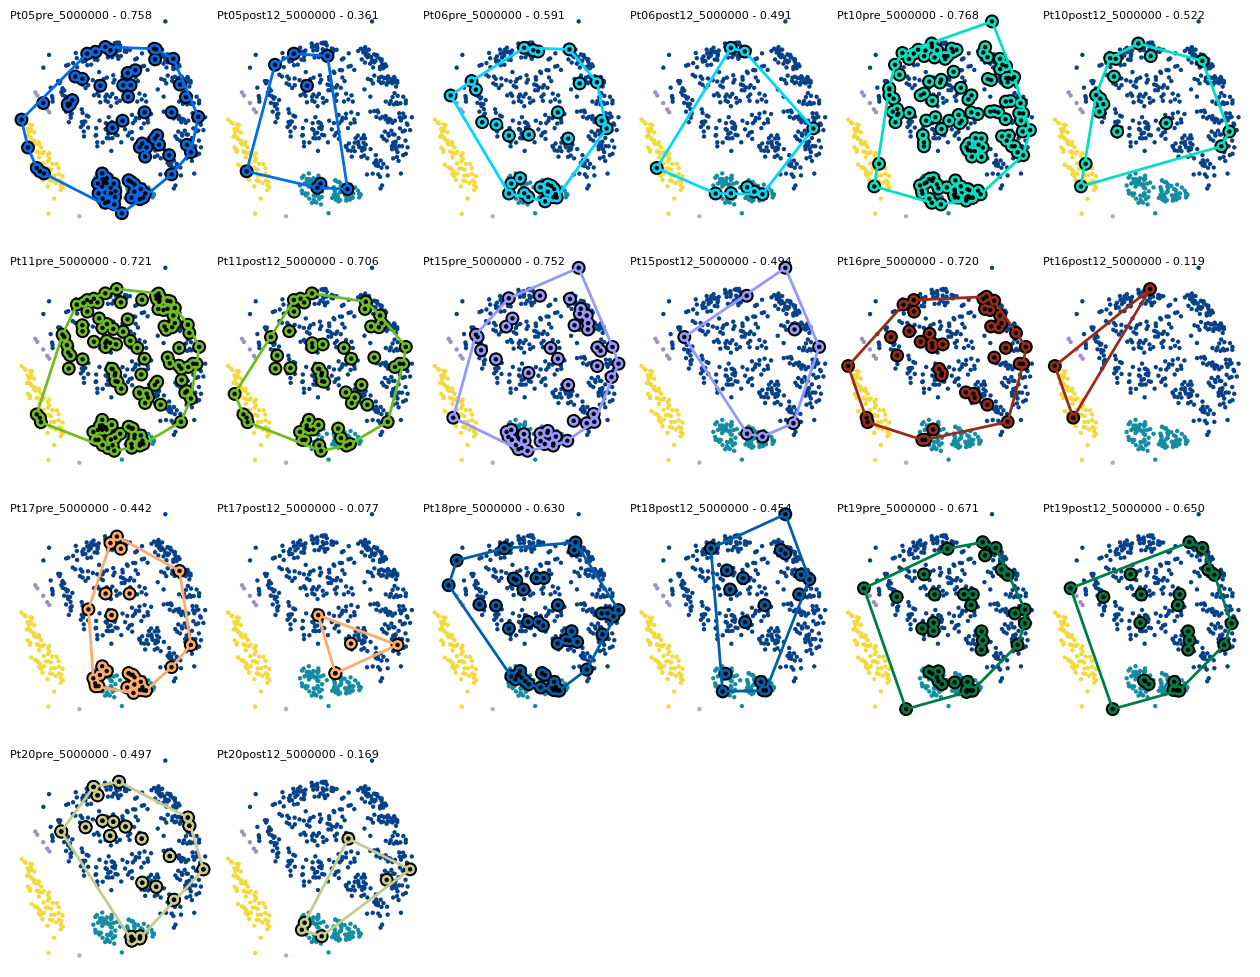

In [25]:
# supplementary figure 8b
paired_pre_post12 =["Pt05pre_5000000", "Pt05post12_5000000", "Pt06pre_5000000", "Pt06post12_5000000", "Pt10pre_5000000", "Pt10post12_5000000", "Pt11pre_5000000",  "Pt11post12_5000000",  
                 "Pt15pre_5000000", "Pt15post12_5000000", "Pt16pre_5000000", "Pt16post12_5000000", "Pt17pre_5000000", "Pt17post12_5000000", "Pt18pre_5000000", "Pt18post12_5000000", 
                 "Pt19pre_5000000", "Pt19post12_5000000", "Pt20pre_5000000", "Pt20post12_5000000"]

for pid in paired_pre_post12:
    target_papi=papi_patient[pid]
    for i in target_papi:
        indices=seq_names["Papi"].index(i)
        pid_coordinates[pid].append(MDS_XY['Papi'][indices])
        pid_seqs[pid].append(indices)

        
# get full area
hull = ConvexHull(np.array(all_coordinates))
sh_poly=Polygon(list(zip(np.array(all_coordinates)[hull.vertices,0],np.array(all_coordinates)[hull.vertices,1])))      
total_area=sh_poly.area


fig = plt.figure(figsize=(8*2,8*2),facecolor='w')
cols = 6
gs = gridspec.GridSpec(len(target_pid)//cols+1,cols,width_ratios=[1 for c in range(cols)],wspace=0.0,hspace=0.0)
col_preoff12 = ["#026BE7", "#026BE7", "#01D8FB", "#01D8FB", "#05DFBF", "#05DFBF", "#6EBD21", "#6EBD21", "#9498FF", "#9498FF", "#972D19", "#972D19", 
         "#FFAB6A", "#FFAB6A", "#005FAB", "#005FAB", "#007C47", "#007C47", "#C5CB8D", "#C5CB8D"]

for p,patient in enumerate(paired_pre_post12):
    distances=[]
    pid_colours[patient]=col_preoff12[p]
    for a,A in enumerate(pid_seqs[patient]):
        for b,B in enumerate(pid_seqs[patient]):
            if b>a:
                distances.append(distance_matrices['Papi'][A][B])
                
    xs,ys=zip(*pid_coordinates[patient]) # define xs, ys
    fc=pid_colours[patient]
    coords=np.array(np.array((xs,ys)).T)
    hull = ConvexHull(coords)
    sh_poly=Polygon(list(zip(coords[hull.vertices,0],coords[hull.vertices,1])))
    
    row=p//cols
    col=p%cols
    ax=plt.subplot(gs[row,col])
    s=5
    ax.scatter(xs,ys,s=s*2,facecolor='k',edgecolor='none',zorder=4)
    ax.scatter(xs,ys,s=s*10,facecolor=fc,edgecolor='none',zorder=3)
    ax.scatter(xs,ys,s=s*20,facecolor='k',edgecolor='none',zorder=2)

    
    for simplex in hull.simplices:
        ax.plot(coords[simplex,0],coords[simplex,1],color=fc,lw=2,ls='-',zorder=3)
        
    area='- %.3f'%(sh_poly.area/total_area) 
    ax.text(0.0,1,'%s %s'%(patient,area),size=8,ha='left',va='top',transform=ax.transAxes)
    ax.scatter(*zip(*all_coordinates),s=10,facecolor=cs,edgecolor='none',zorder=1)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    axs,ays=zip(*all_coordinates)
    ax.set_xlim(min(axs)-0.05,max(axs)+0.05)
    ax.set_ylim(min(ays)-0.05,max(ays)+0.05)

plt.savefig(os.path.join(data_path, 'figures', 'papi_pre_post12_hull_area_from_10m.pdf'),dpi=300,bbox_inches='tight')
plt.show()